C:\Users\bassp\anaconda3\envs\DLC-GPU\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


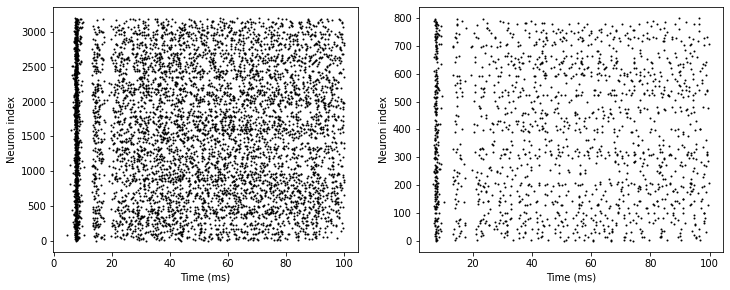

In [1]:
import brainpy as bp
import brainpy.math as bm

import matplotlib.pyplot as plt

bm.set_platform('cpu')

E = bp.neurons.LIF(3200, V_rest=-60., V_th=-50., V_reset=-60.,
                   tau=20., tau_ref=5., method='exp_auto',
                   V_initializer=bp.init.Normal(-60., 2.))

I = bp.neurons.LIF(800, V_rest=-60., V_th=-50., V_reset=-60.,
                   tau=20., tau_ref=5., method='exp_auto',
                   V_initializer=bp.init.Normal(-60., 2.))


E2E = bp.synapses.Exponential(E, E, bp.conn.FixedProb(prob=0.02), g_max=0.6,
                              tau=5., output=bp.synouts.COBA(E=0.),
                              method='exp_auto')

E2I = bp.synapses.Exponential(E, I, bp.conn.FixedProb(prob=0.02), g_max=0.6,
                              tau=5., output=bp.synouts.COBA(E=0.),
                              method='exp_auto')

I2E = bp.synapses.Exponential(I, E, bp.conn.FixedProb(prob=0.02), g_max=6.7,
                              tau=10., output=bp.synouts.COBA(E=-80.),
                              method='exp_auto')

I2I = bp.synapses.Exponential(I, I, bp.conn.FixedProb(prob=0.02), g_max=6.7,
                              tau=10., output=bp.synouts.COBA(E=-80.),
                              method='exp_auto')

net = bp.dyn.Network(E2E, E2I, I2E, I2I, E=E, I=I)

runner = bp.dyn.DSRunner(net,
                         monitors=['E.spike', 'I.spike'],
                         inputs=[('E.input', 20.), ('I.input', 20.)],
                         dt=0.1)

runner.run(100)




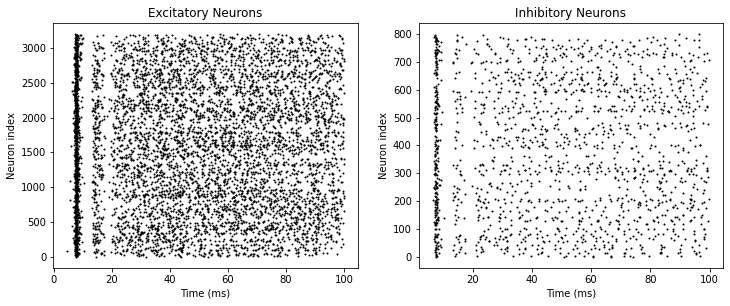

<Figure size 432x288 with 0 Axes>

In [4]:

plt.figure(figsize=(12, 4.5))

plt.subplot(121)

bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'], show=False)
plt.title('Excitatory Neurons')
plt.subplot(122)
plt.title('Inhibitory Neurons')
bp.visualize.raster_plot(runner.mon.ts, runner.mon['I.spike'], show=True)
plt.savefig('EI_network.png')

In [5]:
pre_stimulus_period = 100.  # time before the external simuli are given
stimulus_period = 1000.  # time within which the external simuli are given
delay_period = 500.  # time after the external simuli are removed
total_period = pre_stimulus_period + stimulus_period + delay_period


class PoissonStim(bp.dyn.NeuGroup):
    def __init__(self, size, freq_mean, freq_var, t_interval, **kwargs):
        super(PoissonStim, self).__init__(size=size, **kwargs)

        # initialize parameters
        self.freq_mean = freq_mean
        self.freq_var = freq_var
        self.t_interval = t_interval

        # initialize variables
        self.freq = bm.Variable(bm.zeros(1))
        self.freq_t_last_change = bm.Variable(bm.ones(1) * -1e7)
        self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
        self.rng = bm.random.RandomState()

    def update(self, tdi):
        in_interval = bm.logical_and(pre_stimulus_period < tdi.t, tdi.t < pre_stimulus_period + stimulus_period)
        freq = bm.where(in_interval, self.freq[0], 0.)
        change = bm.logical_and(in_interval, (tdi.t - self.freq_t_last_change[0]) >= self.t_interval)
        self.freq[:] = bm.where(change, self.rng.normal(self.freq_mean, self.freq_var), freq)
        self.freq_t_last_change[:] = bm.where(change, tdi.t, self.freq_t_last_change[0])
        self.spike.value = self.rng.random(self.num) < self.freq[0] * tdi.dt / 1000.
    
    

class DecisionMaking(bp.dyn.Network):
    def __init__(self, scale=1., mu0=40., coherence=25.6, f=0.15, dt=bm.get_dt()):
        super(DecisionMaking, self).__init__()

        # initialize neuron-group parameters
        num_exc = int(1600 * scale)
        num_inh = int(400 * scale)
        num_A = int(f * num_exc)
        num_B = int(f * num_exc)
        num_N = num_exc - num_A - num_B
        poisson_freq = 2400.  # Hz

        # initialize synapse parameters
        w_pos = 1.7
        w_neg = 1. - f * (w_pos - 1.) / (1. - f)
        g_ext2E_AMPA = 2.1  # nS
        g_ext2I_AMPA = 1.62  # nS
        g_E2E_AMPA = 0.05 / scale  # nS
        g_E2I_AMPA = 0.04 / scale  # nS
        g_E2E_NMDA = 0.165 / scale  # nS
        g_E2I_NMDA = 0.13 / scale  # nS
        g_I2E_GABAa = 1.3 / scale  # nS
        g_I2I_GABAa = 1.0 / scale  # nS

        # parameters of the AMPA synapse
        ampa_par = dict(delay_step=int(0.5 / dt), tau=2.0, output=bp.synouts.COBA(E=0.))

        # parameters of the GABA synapse
        gaba_par = dict(delay_step=int(0.5 / dt), tau=5.0, output=bp.synouts.COBA(E=-70.))

        # parameters of the NMDA synapse
        nmda_par = dict(delay_step=int(0.5 / dt), tau_decay=100, tau_rise=2.,
                        a=0.5, output=bp.synouts.MgBlock(E=0., cc_Mg=1.))

        # excitatory and inhibitory neuron groups, A, B, N, and I
        A = bp.neurons.LIF(num_A, V_rest=-70., V_reset=-55., V_th=-50., tau=20., R=0.04,
                           tau_ref=2., V_initializer=bp.init.OneInit(-70.))
        B = bp.neurons.LIF(num_B, V_rest=-70., V_reset=-55., V_th=-50., tau=20., R=0.04,
                           tau_ref=2., V_initializer=bp.init.OneInit(-70.))
        N = bp.neurons.LIF(num_N, V_rest=-70., V_reset=-55., V_th=-50., tau=20., R=0.04,
                           tau_ref=2., V_initializer=bp.init.OneInit(-70.))
        I = bp.neurons.LIF(num_inh, V_rest=-70., V_reset=-55., V_th=-50., tau=10., R=0.05,
                           tau_ref=1., V_initializer=bp.init.OneInit(-70.))

        # neurons generating external inputs, I_A and I_B
        IA = PoissonStim(num_A, freq_var=10., t_interval=50., freq_mean=mu0 + mu0 / 100. * coherence)
        IB = PoissonStim(num_B, freq_var=10., t_interval=50., freq_mean=mu0 - mu0 / 100. * coherence)

        # noise neurons
        self.noise_A = bp.neurons.PoissonGroup(num_A, freqs=poisson_freq)
        self.noise_B = bp.neurons.PoissonGroup(num_B, freqs=poisson_freq)
        self.noise_N = bp.neurons.PoissonGroup(num_N, freqs=poisson_freq)
        self.noise_I = bp.neurons.PoissonGroup(num_inh, freqs=poisson_freq)

        # connection from excitatory neurons to others
        self.N2B_AMPA = bp.synapses.Exponential(N, B, bp.conn.All2All(), g_max=g_E2E_AMPA * w_neg, **ampa_par)
        self.N2A_AMPA = bp.synapses.Exponential(N, A, bp.conn.All2All(), g_max=g_E2E_AMPA * w_neg, **ampa_par)
        self.N2N_AMPA = bp.synapses.Exponential(N, N, bp.conn.All2All(), g_max=g_E2E_AMPA, **ampa_par)
        self.N2I_AMPA = bp.synapses.Exponential(N, I, bp.conn.All2All(), g_max=g_E2I_AMPA, **ampa_par)
        self.N2B_NMDA = bp.synapses.NMDA(N, B, bp.conn.All2All(), g_max=g_E2E_NMDA * w_neg, **nmda_par)
        self.N2A_NMDA = bp.synapses.NMDA(N, A, bp.conn.All2All(), g_max=g_E2E_NMDA * w_neg, **nmda_par)
        self.N2N_NMDA = bp.synapses.NMDA(N, N, bp.conn.All2All(), g_max=g_E2E_NMDA, **nmda_par)
        self.N2I_NMDA = bp.synapses.NMDA(N, I, bp.conn.All2All(), g_max=g_E2I_NMDA, **nmda_par)

        self.B2B_AMPA = bp.synapses.Exponential(B, B, bp.conn.All2All(), g_max=g_E2E_AMPA * w_pos, **ampa_par)
        self.B2A_AMPA = bp.synapses.Exponential(B, A, bp.conn.All2All(), g_max=g_E2E_AMPA * w_neg, **ampa_par)
        self.B2N_AMPA = bp.synapses.Exponential(B, N, bp.conn.All2All(), g_max=g_E2E_AMPA, **ampa_par)
        self.B2I_AMPA = bp.synapses.Exponential(B, I, bp.conn.All2All(), g_max=g_E2I_AMPA, **ampa_par)
        self.B2B_NMDA = bp.synapses.NMDA(B, B, bp.conn.All2All(), g_max=g_E2E_NMDA * w_pos, **nmda_par)
        self.B2A_NMDA = bp.synapses.NMDA(B, A, bp.conn.All2All(), g_max=g_E2E_NMDA * w_neg, **nmda_par)
        self.B2N_NMDA = bp.synapses.NMDA(B, N, bp.conn.All2All(), g_max=g_E2E_NMDA, **nmda_par)
        self.B2I_NMDA = bp.synapses.NMDA(B, I, bp.conn.All2All(), g_max=g_E2I_NMDA, **nmda_par)

        self.A2B_AMPA = bp.synapses.Exponential(A, B, bp.conn.All2All(), g_max=g_E2E_AMPA * w_neg, **ampa_par)
        self.A2A_AMPA = bp.synapses.Exponential(A, A, bp.conn.All2All(), g_max=g_E2E_AMPA * w_pos, **ampa_par)
        self.A2N_AMPA = bp.synapses.Exponential(A, N, bp.conn.All2All(), g_max=g_E2E_AMPA, **ampa_par)
        self.A2I_AMPA = bp.synapses.Exponential(A, I, bp.conn.All2All(), g_max=g_E2I_AMPA, **ampa_par)
        self.A2B_NMDA = bp.synapses.NMDA(A, B, bp.conn.All2All(), g_max=g_E2E_NMDA * w_neg, **nmda_par)
        self.A2A_NMDA = bp.synapses.NMDA(A, A, bp.conn.All2All(), g_max=g_E2E_NMDA * w_pos, **nmda_par)
        self.A2N_NMDA = bp.synapses.NMDA(A, N, bp.conn.All2All(), g_max=g_E2E_NMDA, **nmda_par)
        self.A2I_NMDA = bp.synapses.NMDA(A, I, bp.conn.All2All(), g_max=g_E2I_NMDA, **nmda_par)

        # connection from inhibitory neurons to others
        self.I2B = bp.synapses.Exponential(I, B, bp.conn.All2All(), g_max=g_I2E_GABAa, **gaba_par)
        self.I2A = bp.synapses.Exponential(I, A, bp.conn.All2All(), g_max=g_I2E_GABAa, **gaba_par)
        self.I2N = bp.synapses.Exponential(I, N, bp.conn.All2All(), g_max=g_I2E_GABAa, **gaba_par)
        self.I2I = bp.synapses.Exponential(I, I, bp.conn.All2All(), g_max=g_I2I_GABAa, **gaba_par)

        # connection from external inputs to selective neuron groups
        self.IA2A = bp.synapses.Exponential(IA, A, bp.conn.One2One(), g_max=g_ext2E_AMPA, **ampa_par)
        self.IB2B = bp.synapses.Exponential(IB, B, bp.conn.One2One(), g_max=g_ext2E_AMPA, **ampa_par)

        # connectioni from noise neurons to excitatory and inhibitory neurons
        self.noise2B = bp.synapses.Exponential(self.noise_B, B, bp.conn.One2One(), g_max=g_ext2E_AMPA, **ampa_par)
        self.noise2A = bp.synapses.Exponential(self.noise_A, A, bp.conn.One2One(), g_max=g_ext2E_AMPA, **ampa_par)
        self.noise2N = bp.synapses.Exponential(self.noise_N, N, bp.conn.One2One(), g_max=g_ext2E_AMPA, **ampa_par)
        self.noise2I = bp.synapses.Exponential(self.noise_I, I, bp.conn.One2One(), g_max=g_ext2I_AMPA, **ampa_par)

        # add A, B, I, N to the class
        self.A = A
        self.B = B
        self.N = N
        self.I = I
        self.IA = IA
        self.IB = IB
        
net = DecisionMaking(scale=1., coherence=25.6, mu0=40.)
runner = bp.dyn.DSRunner(net, monitors=['A.spike', 'B.spike', 'IA.freq', 'IB.freq'])

runner.run(total_period)

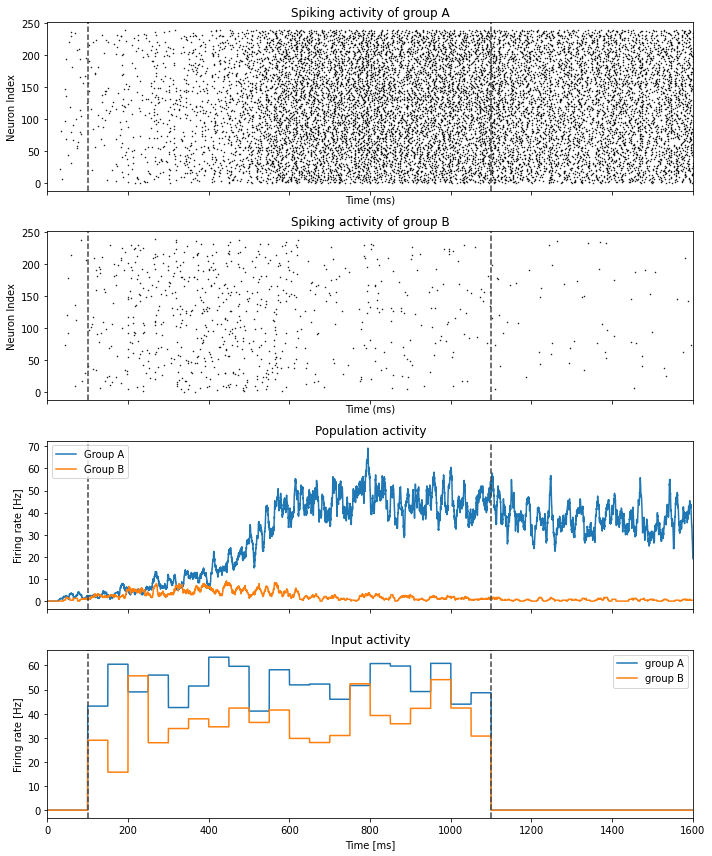

In [6]:
fig, gs = plt.subplots(4, 1, figsize=(10, 12), sharex='all')
t_start = 0.

# the raster plot of A
fig.add_subplot(gs[0])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['A.spike'], markersize=1)
plt.title("Spiking activity of group A")
plt.ylabel("Neuron Index")

# the raster plot of A
fig.add_subplot(gs[1])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['B.spike'], markersize=1)
plt.title("Spiking activity of group B")
plt.ylabel("Neuron Index")

# the firing rate of A and B
fig.add_subplot(gs[2])
rateA = bp.measure.firing_rate(runner.mon['A.spike'], width=10.)
rateB = bp.measure.firing_rate(runner.mon['B.spike'], width=10.)
plt.plot(runner.mon.ts, rateA, label="Group A")
plt.plot(runner.mon.ts, rateB, label="Group B")
plt.ylabel('Firing rate [Hz]')
plt.title("Population activity")
plt.legend()

# the external stimuli
fig.add_subplot(gs[3])
plt.plot(runner.mon.ts, runner.mon['IA.freq'], label="group A")
plt.plot(runner.mon.ts, runner.mon['IB.freq'], label="group B")
plt.title("Input activity")
plt.ylabel("Firing rate [Hz]")
plt.legend()

for i in range(4):
  gs[i].axvline(pre_stimulus_period, linestyle='dashed', color=u'#444444')
  gs[i].axvline(pre_stimulus_period + stimulus_period, linestyle='dashed', color=u'#444444')

plt.xlim(t_start, total_period + 1)
plt.xlabel("Time [ms]")
plt.tight_layout()
plt.show()